In [52]:
from __future__ import annotations
from collections import defaultdict
import csv
from datetime import date
from pydantic import BaseModel
import numpy as np
import matplotlib.pyplot as plt

import go.stats.game_results as mr
import go.stats.ratings as ratings
from go.stats.player_stats import Stats
from go.stats.game_results import GameResult


In [53]:
# load the game results and filter 
results: list[GameResult] = []
prev_ratings: dict[str, float] = {}

# # for weird S10 stuff
# season = 's10'
# prev_ratings = ratings.load_ratings('../data/after_s10/go_s10_ratings.csv')

# for row in mr.load_game_results('../data/after_s10/GO-P1 S10 Results.csv'):
#         # ghosty and ferrari switched igns for fun for a game
#         if row.playfabid == 'ACC91C345732CA5E': row.ign = 'Mr._.Ferrari'
#         if row.playfabid == '54127A904055A317': 
#             row.ign = 'RBL_Ghosty'
#             row.playfabid2 = 'B50A4AC40327843C'
#         if row.ign == "about.com": 
#             continue # he didn't have an original rating
#         results.append(row)

season = 's11'
prev_ratings = ratings.load_ratings('../data/after_s11/go_official_s11_ratings.csv')

for row in mr.load_results('../data/after_s11/gop1_s11_results.csv'):
        results.append(row)


loaded 3355 ratings
before filtering out fun games 3136
after filtering out fun games 3102


In [54]:
# go through the seasons game results
# and build up playfab <--> ign mappings
# and team rosters

pfab2_to_ign = dict()
ign_to_pfab2 = dict()
team_pfabs = defaultdict(set) # rosters each lobby

duplicate_igns = []

for r in results:
    if r.ign != 'TOTALS':
        team_pfabs[(r.lobby, r.game, r.team)].add(r.playfabid2)
        pfab2_to_ign[r.playfabid2] = r.ign
        if r.ign in ign_to_pfab2:
            if ign_to_pfab2[r.ign] != r.playfabid2:
                duplicate_igns.append((r.ign, r.playfabid2, ign_to_pfab2[r.ign]))
        ign_to_pfab2[r.ign] = r.playfabid2
    else:
        pfab2_to_ign[r.playfabid2] = 'TOTALS'

# fail if ign -> playfabid2 is not 1-1
if duplicate_igns:
    for (ign, pfab2, pfab2_from_prev_result) in duplicate_igns:
        print(f'{ign = } {pfab2 = } {pfab2_from_prev_result = }')
assert len(duplicate_igns) == 0

# set team_size and ign2 for each game result
for r in results:
    pfabs = team_pfabs[(r.lobby, r.game, r.team)]
    r.team_size = len(pfabs)
    r.ign2 = pfab2_to_ign[r.playfabid2]
    r.roster = set([pfab2_to_ign[pfab] for pfab in pfabs])
    
messed_up_ratings = []

# accumulate stats for each (player,teamsize)
ign_size_to_stats = defaultdict(lambda: defaultdict(Stats))
for r in results:
    stats = ign_size_to_stats[r.ign2][r.team_size]
    stats.add_game(r.placement, r.kills, r.damage)
    stats.ign = r.ign2
    stats.playfab = r.playfabid2
    stats.team_size = r.team_size

    if stats.orig_rating is not None and stats.orig_rating != prev_ratings.get(r.playfabid2):    
        messed_up_ratings.append((r.ign2, r.team_size, stats.orig_rating, prev_ratings.get(r.playfabid2)))
        
    stats.orig_rating = prev_ratings.get(r.playfabid2)
    
if messed_up_ratings:
    # someone has different ratings for their different playfabs
    for (ign, ts, orig_rating, prev_rating) in messed_up_ratings:
        print(f'{ign = } {ts = } {orig_rating = } {prev_rating = }')
assert len(messed_up_ratings) == 0
        



# print out players
name_to_print = "TOTALS"
for ign2, team_size_to_stats in sorted(ign_size_to_stats.items()):
    for team_size, stats in sorted(team_size_to_stats.items()):    
        if ign2.lower().count(name_to_print.lower()) ==0:
            continue
        print(f'{ign2:25} ts={team_size}  {stats}  rating={stats.go_rating():.0f}')

# print(1, ign_size_to_stats['TOTALS'][1])
# print(2, ign_size_to_stats['TOTALS'][2])
# print(3, ign_size_to_stats['TOTALS'][3])
# print('S', ign_size_to_stats['GO_STOOOBE'][3])


TOTALS                    ts=1  g=167  wr=0.04  kpg=0.98  dpg=280  rating=242.61  rating=243
TOTALS                    ts=2  g=272  wr=0.13  kpg=3.92  dpg=1174  rating=990.97  rating=991
TOTALS                    ts=3  g=488  wr=0.16  kpg=4.70  dpg=1493  rating=1230.88  rating=1231


In [55]:
def run_regr(x, y, degrees=[1]):
    x = np.array(x)
    matrix = np.stack([x**d for d in degrees], axis=-1)   # stack them like columns
    coefs, _, _, _ = np.linalg.lstsq(matrix, y)
    return coefs

def plot_regr_line(coefs, xrange, degrees=[1],  **plot_args):
    xseq = np.linspace(xrange[0], xrange[1], num=100)
    xseq_matrix = np.stack([xseq**d for d in degrees], axis=-1)   # stack them like columns
    yhat = np.matmul(xseq_matrix, coefs)
    plt.plot(xseq, yhat, **plot_args)
    
class WeightedMean:
    def __init__(self):
        self.total = 0.0
        self.weight = 0.0
        self.count = 0.0
    def add(self, value, weight):
        self.total += value * weight
        self.weight += weight
        self.count += 1
    def mean(self) -> float | None:
        if not self.count:
            return None
        return self.total / self.weight

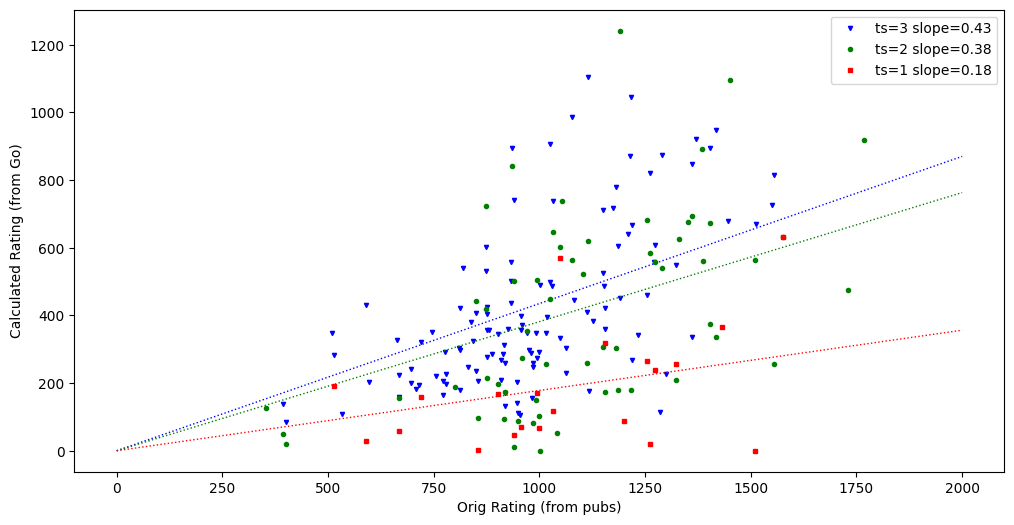

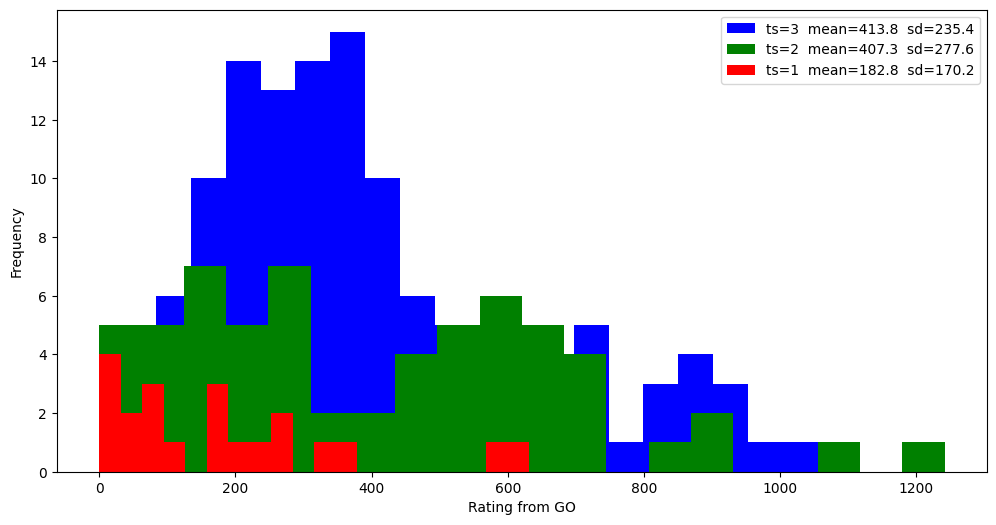

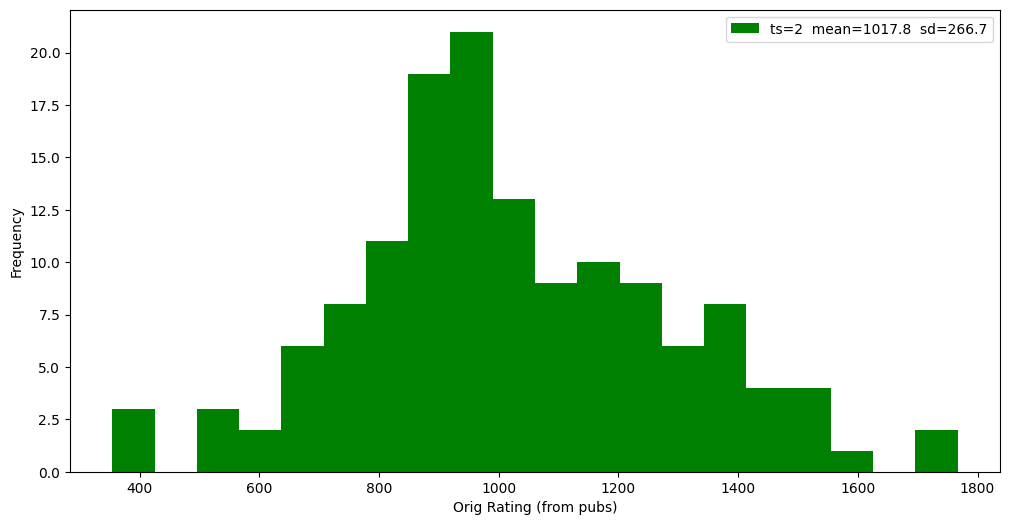

ts=0  mean=1017.8  sd=266.7
ts=1  mean=182.8  sd=170.2
ts=2  mean=407.3  sd=277.6
ts=3  mean=413.8  sd=235.4


In [56]:
degrees = [1]


marks =  ['', 's', 'o', 'v'] 
colors = ['', 'r', 'g', 'b']

plt.figure(figsize=(12,6))
for ts in [3, 2, 1]:
    x = []
    y = []
    for ign, ts_to_stats in ign_size_to_stats.items():
        if ign=='TOTALS':
            continue
        if ts not in ts_to_stats: 
            continue
        stats = ts_to_stats[ts]
        if stats.orig_rating is not None and stats.go_rating() is not None:
            x.append(stats.orig_rating)
            y.append(stats.go_rating())

    
    degrees = [1]
    coefs = run_regr(x, y, degrees)
    plot_regr_line(coefs, xrange=[0,2000], degrees=degrees, linestyle=':',  color=colors[ts], lw=1)
    
    plt.plot(x, y,             
            marker=marks[ts],
            color=colors[ts],
            markerfacecolor=colors[ts],
            linestyle='None',
            ms=3,
            label=f'ts={ts} slope={coefs[0] :.2f}')

plt.xlabel("Orig Rating (from pubs)")
plt.ylabel("Calculated Rating (from Go)")
plt.legend(numpoints=1)
plt.show()

ts_to_rating_mn_sd = dict()

plt.figure(figsize=(12,6))
for ts in [3, 2, 1]:
    x = []
    for ign, ts_to_stats in ign_size_to_stats.items():
        if ign=='TOTALS':
            continue
        if ts not in ts_to_stats: 
            continue
        stats = ts_to_stats[ts]
        if stats.go_rating() is not None:
            x.append(stats.go_rating())
    
    x = np.array(x)
    ts_to_rating_mn_sd[ts] = (x.mean(), x.std())
    plt.hist(x, bins=20,
            color=colors[ts],
            # histtype='step',
            label=f'ts={ts}  mean={x.mean():.1f}  sd={x.std():.1f}')

plt.xlabel("Rating from GO")
plt.ylabel("Frequency")
plt.legend(numpoints=1)
plt.show()


plt.figure(figsize=(12,6))
x = []
for ign, ts_to_stats in ign_size_to_stats.items():
    if ign=='TOTALS':
        continue
    for ts,stats in ts_to_stats.items():
        if stats.orig_rating is not None:
            x.append(stats.orig_rating)
            break

x = np.array(x)
ts_to_rating_mn_sd[0] = (x.mean(), x.std())
plt.hist(x, bins=20,
        color=colors[ts],
        label=f'ts={ts}  mean={x.mean():.1f}  sd={x.std():.1f}')

plt.xlabel("Orig Rating (from pubs)")
plt.ylabel("Frequency")
plt.legend(numpoints=1)
plt.show()

for ts, (mn, sd) in sorted(ts_to_rating_mn_sd.items()):
    print(f'ts={ts}  mean={mn:.1f}  sd={sd:.1f}')

FlashBolo g=1  wr=1.00  kpg=3.00  dpg=1326  rating=1241.43
TTV_CaseOh g=5  wr=0.00  kpg=4.20  dpg=888  rating=843.05


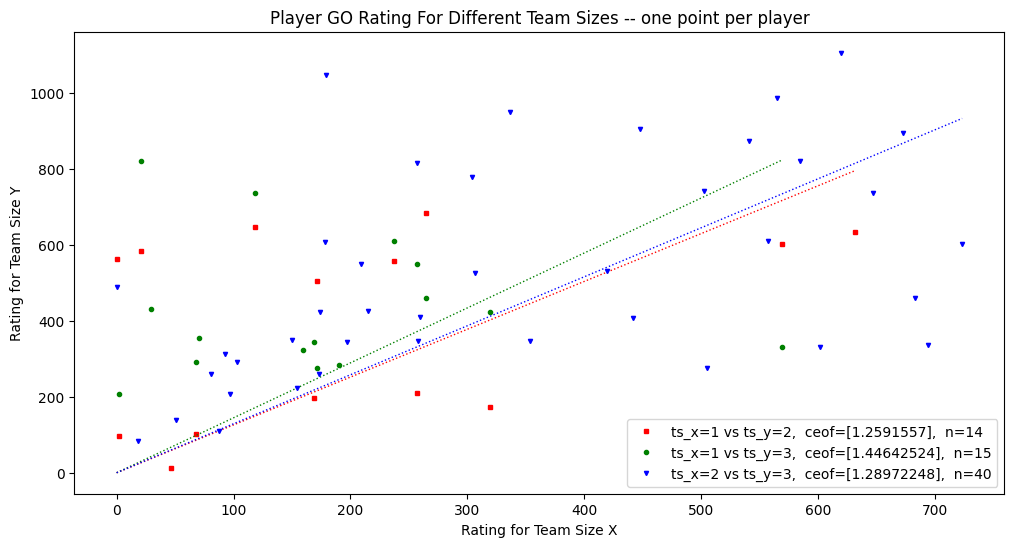

TOTALS 1 g=167  wr=0.04  kpg=0.98  dpg=280  rating=242.61
TOTALS 2 g=272  wr=0.13  kpg=3.92  dpg=1174  rating=990.97
TOTALS 3 g=488  wr=0.16  kpg=4.70  dpg=1493  rating=1230.88
1, 2 --> 1.26   totals_ratio: 4.085
1, 3 --> 1.45   totals_ratio: 5.073
2, 3 --> 1.29   totals_ratio: 1.242


In [57]:

plt.figure(figsize=(12,6))

ts_adjustements = dict()

for tsx,tsy,color,mark in [(1,2,'r','s'), (1,3,'g','o'), (2,3,'b','v')]:
    x = []
    y = []

    for ign, ts_to_stats in sorted(ign_size_to_stats.items()):
        if ign=="TOTALS":
            continue
        if tsx in ts_to_stats and tsy in ts_to_stats:
            if ts_to_stats[tsx].go_rating() > 800:
                print(ign,ts_to_stats[tsx])
                continue
            x.append(ts_to_stats[tsx].go_rating())
            y.append(ts_to_stats[tsy].go_rating())


    coefs = run_regr(x, y, degrees=[1])
    plot_regr_line(coefs, degrees=degrees, linestyle=':', xrange=[0,max(x)], color=color, lw=1)

    ts_adjustements[(tsx,tsy)] = coefs[0]

    plt.plot(x, y,             
            marker=mark,
            color=color,            
            linestyle='None',
            ms=3,
            label=f'ts_x={tsx} vs ts_y={tsy},  ceof={coefs},  n={len(x)}')
    
    
plt.title("Player GO Rating For Different Team Sizes -- one point per player")
plt.xlabel("Rating for Team Size X")
plt.ylabel("Rating for Team Size Y")
plt.legend(numpoints=1)
plt.show()

totals = ign_size_to_stats['TOTALS']
for ts, stats in sorted(totals.items()):
    print('TOTALS',ts,stats)

for (tsx, tsy), adj in sorted(ts_adjustements.items()):
    print(f'{tsx}, {tsy} --> {adj:.2f}   totals_ratio: {totals[tsy].go_rating() / totals[tsx].go_rating() :.3f}')

In [78]:
# compute for each player different types of adjusted ratings
# dict[ign][rating type] --> rating

ign_to_adj_ratings = defaultdict(lambda: defaultdict(float))

for ign, ts_to_stats in sorted(ign_size_to_stats.items()):
    if ign=="TOTALS":
        continue
    
    ###########################################
    ## caclulate adjusted rating from regr coefs
    orig_rating = None
    rating_adj_wm = WeightedMean()
    
    for ts,stats in sorted(ts_to_stats.items()):
        assert orig_rating is None or orig_rating == stats.orig_rating
        orig_rating = stats.orig_rating
        
        adj = ts_adjustements[(ts,3)] if ts!=3 else 1
        rating_adj_wm.add(stats.go_rating() * adj, stats.games)
        
        # raw rating from this team size
        ign_to_adj_ratings[ign][f'TS_{ts}'] = stats.go_rating()

    # print(ign,rating_adj,ratings,gs)
    ign_to_adj_ratings[ign]['REGR_COEF'] = rating_adj_wm.mean()  # type: ignore
    ign_to_adj_ratings[ign]['ORIG'] = orig_rating # type: ignore
    
    
    ###########################################
    ## caclulate adjusted rating from zscores
    
    zscore_wm = WeightedMean()
    
    for ts,stats in sorted(ts_to_stats.items()):
        mn,sd = ts_to_rating_mn_sd[ts]
        zscore = (stats.go_rating() - mn) / sd
        zscore_wm.add(zscore, stats.games)
    
    mn,sd = ts_to_rating_mn_sd[0]    
    confidence_factor15 = min(1,max(0,zscore_wm.weight/15.0))
    confidence_factor60 = min(1,max(0,zscore_wm.weight/60.0))
    
    rating_adj_z = sd * zscore + mn
    
    
    if orig_rating is None:
        print(f"missing orig rating for: ign = {ign}  pfab = {ign_to_pfab2[ign]}  zscore_rating = {float(rating_adj_z):.1f}")
        orig_rating = 0
        confidence_factor15 = 1
        confidence_factor60 = 1
    
    rating_adj_z_reduced = rating_adj_z*confidence_factor15 + (1-confidence_factor15)*orig_rating
    rating_adj_z_reduced2 = rating_adj_z*confidence_factor60 + (1-confidence_factor60)*orig_rating

    ign_to_adj_ratings[ign]['ZSCORE'] = rating_adj_z    
    ign_to_adj_ratings[ign]['ZSCORE_REDUCED'] = rating_adj_z_reduced
    ign_to_adj_ratings[ign]['ZSCORE_REDUCED_ASYM'] = rating_adj_z_reduced2 if rating_adj_z < orig_rating else rating_adj_z_reduced

    ign_to_adj_ratings[ign]['games'] = zscore_wm.weight    


if season=="s11":
    del ign_to_adj_ratings['colinthe5']
    del ign_to_adj_ratings['U_Died']

missing orig rating for: ign = CornBall  pfab = 3DB603736D04A0BC  zscore_rating = 1101.0
missing orig rating for: ign = D.MENACE1.209  pfab = E0A123C5CA062D68  zscore_rating = 756.1
missing orig rating for: ign = HYX_Wilbur.111678  pfab = 641BE86047DE2192  zscore_rating = 844.0
missing orig rating for: ign = SADDAM  pfab = B77C2F6D0CD2FDF4  zscore_rating = 910.2
missing orig rating for: ign = TBEEMoney  pfab = 3F5D4AFC2A01604D  zscore_rating = 811.7
missing orig rating for: ign = colinthe5  pfab = 764263C2E1E43C7C  zscore_rating = 895.8


In [79]:
# write out all the adjusted ratings to analyze

with open(f"../go_post_{season}_adjusted_ratings.csv", 'w') as f:
    all_keys = set()
    for ign, name_to_adj_ratings in sorted(ign_to_adj_ratings.items()):
        all_keys.update(name_to_adj_ratings.keys())
    # print(f'ign,{",".join(sorted(all_keys))}')
    # header = 'ign,ORIG,TS_1,TS_2,TS_3,REGR_COEF,ZSCORE,ZSCORE_REDUCED'.split(',')
    header = 'ign,games,ORIG,ZSCORE,ZSCORE_REDUCED,ZSCORE_REDUCED_ASYM'.split(',')
    f.write(','.join(header))
    f.write('\n')
    for ign, name_to_adj_ratings in sorted(ign_to_adj_ratings.items()):
        f.write(f'{ign},{",".join([f"{name_to_adj_ratings[_] or 0.0:.3f}" for _ in header[1:]])}')
        f.write('\n')   


In [80]:
# write out the best rating type

rating_type_to_use = 'ZSCORE_REDUCED_ASYM'

with open(f"../go_post_{season}.to_load.csv", 'w') as f:
    header = 'ign,pfid,orig_rating,go_rating'.split(',')
    f.write(','.join(header))
    f.write('\n')
    for ign, name_to_adj_ratings in sorted(ign_to_adj_ratings.items()):
        pfid = ign_to_pfab2[ign]
        
        f.write(f'{ign},{pfid},{name_to_adj_ratings["ORIG"] or 0.0:0.1f},{name_to_adj_ratings[rating_type_to_use]:0.1f}')
        f.write('\n')   

In [ ]:
# import sys, csv


# # workspace = "/Users/stube/Documents/developer/GoBot/"
# # if workspace not in sys.path:
# #     sys.path.append(workspace)

# from go.playfab_api import as_playfab_id

# with open("../go_official_s11_ratings.pre_fixed_id.csv", 'r') as file:
#     with open("../go_official_s11_ratings.csv", 'w') as fout:
        
#         csv_reader = csv.DictReader(f=file)
#         fout.write("pfid,ign,go_rating\n")
#         for row in csv_reader:
#             row['id'] = int(row['id'])
#             row['pfid'] = as_playfab_id(int(row['id']))
#             fout.write(f"{row['pfid']},{row['ign']},{row['go_rating']}\n")
